## Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# Dinâmica de Sistemas Estruturais


### Análise de Treliça Plana (Teoria e codificação em Python3)



[1.   Apresentando o Problema](#section_1)  
[2.   Apresentando o Código](#section_2)  
[3.   Resultados](#section_3)  
[4.   Validação](#section_4)  
[5.   Referências](#section_5)  

---
_Mestrando. Alex Koch de Almeida._ [(Lattes)](http://lattes.cnpq.br/7734327250758963)  
_Porto Alegre, RS, Brazil_ 


In [157]:
#Importando os módulos do Python a serem utilizados pelo código
#Esta célula deve ser executada antes de qualquer outra
import numpy as np 
from numpy.linalg import norm
from scipy.linalg import eigh
import matplotlib.pyplot as plt 

## 1. Apresentando o Problema <a name="section_1"></a> 

Na figura abaixo está representada a treliça plana a ser utilizada neste artigo:

<img src="img/img1.png" width="460px"/>

Primeiramente vamos definir a notação a ser utilizada para a descrição geométrica do problema: 

<img src="img/img2.png" width="460px"/>

Onde:

$N$: nó próximo, ou seja, nó inicial da descrição geométrica onde posicionam-se os eixos X e Y Globais &nbsp;

$F$: nó afastado, ou seja, nó final da descrição geométrica &nbsp;

$\theta_x$: ângulo iniciado no eixo $X$ (global) e finalizado no eixo $X_L$ (local), em sentido anti-horário&nbsp;


$\theta_y$: ângulo iniciado no eixo $X_L$ (local) e finalizado no eixo $Y$ (global), em sentido anti-horário&nbsp;

**Adotando portanto, para o problema proposto a seguinte configuração:**&nbsp;

Barra 1: N = 1; F = 3&nbsp;

Barra 2: N = 2; F = 3&nbsp;

Barra 3: N = 1; F = 2&nbsp;

**Unidades a serem utilizadas:**&nbsp;

Comprimento = m&nbsp;

Força = kN&nbsp;

**Método a ser utilizado:**&nbsp;

Método dos deslocamentos

## 2. Apresentando o Código <a name="section_2"></a> 

O presente código está organizado em uma rotina **principal** do tipo `def` que divide-se em uma ordem lógica de processos e, dentro de cada processo, existem sub-rotinas do tipo `def` que de fato manipulam os dados e resolvem o problema:

In [158]:
# def main():
#     # Configuração do Problema
#       # Comentários:
#        #atribui a rotina config() à palavra chave "propriedades"
#        #sempre que a palavra propriedades for usada, será possivel acessar os dados da rotina config()
#     propriedades = config()

#     # Determinando as Matrizes Globais
#     M, K, P = matrizes(propriedades)

#     # Calculando as frequências naturais
#     evals, evecs = eigh(K,M)
#     freq = np.sqrt(evals)

#     # Calculando os deslocamentos estáticos de cada elemento
#     U = np.linalg.inv(K).dot(P)

#     # Determinando as tensões em cada elemento
#     f_axial = det_f_axial(propriedades, U)

#     # Resultados
#     exibir_resultados(U, f_axial, freq)

O primeiro conjunto de rotinas objetivam descrever geometricamente o problema de forma legível e manipulável pelo Python:

In [159]:
def config():
    # Comentários: 
      #As bibliotecas de conjuntos de dados são organizadas em chaves {}
      #Os conjuntos de dados sao organizados em colchetes []
      #Exemplo: Biblioteca = { conjunto_de_dados[dado1,dado2]} 
        
    # Definindo o sistema de coordenadas
     # Comentários:
       #Busca-se definir um vetor de comprimento unitário em x e y 
       #para o posterior cálculo dos cossenos diretores
    x_eixo = np.array([1,0]) #np.array([x,y]) resultando em um vetor com uma coordenada 
    y_eixo = np.array([0,1]) #np.array([x,y]) resultando em um vetor com uma coordenada
   
    # Definindo o modelo
      # Comentários:
       #Descreve-se numericamente os nós, elementos, graus de liberdade e cargas em coordenadas cartesianas    
    nos                = { 1:[0,0], 2:[5,0], 3:[3.2,2.4]} # {Nó:[x,y]}
    graus_de_liberdade = { 1:[1,2], 2:[3,4], 3:[5,6] }    # {Nó:[u,v]}
    elementos          = { 1:[1,3], 2:[2,3], 3:[1,2] }    # {Barra:[N,F]}
    gl_restringidos    = [1, 2, 4]                        # Graus de liberdade Restringidos
    cargas             = { 1:[0,0], 2:[0,0], 3:[5,-10] }  # {Nó:[Px,Py]}

    # Propriedades do Material
    densidades     = {1:78.5, 2:78.5, 3:78.5}        # {Barra:densidade}
    modulos_elast  = {1:2.05e8, 2:2.05e8, 3:2.05e8}  # {Barra:E}
    
    # Propriedades Geométricas
      # Comentários:
       #len(conjunto) retorna a quantidade de itens em um conjunto    
    areas = {1:0.1, 2:0.1, 3:0.1} #{Barra:área}
    ngls  = 2 * len(nos)          #Número de graus de liberdade do Problema = g.l por nó * número de nós

    # Afirmações (conferência da convergência dos dados)
      # Comentários:
       #Deseja-se conferir se todas as informações foram fornecidas igualando comprimentos de dados iguais
       #Se algum dado for esquecido o código retornará um erro     
    assert len(densidades) == len(elementos) == len(modulos_elast) == len(areas)
    assert len(gl_restringidos) < ngls
    assert len(cargas) == len(nos)

    # Finalizando a rotina
      # Comentários:
       #O conjunto return{} define nomes arbitrários (entre '') para os diversos dados 
       #calculados pela rotina config()
       #Os dados elencados em return{} podem ser acessados ao usar a rotina config()
       #Para acessar esses dados posteriormente, basta chamar a rotina config() e o nome_do_dado        
    return {  'x_eixo':x_eixo, 'y_eixo':y_eixo, 'nos':nos, 'graus_de_liberdade':graus_de_liberdade,   \
              'elementos':elementos, 'gl_restringidos':gl_restringidos, 'cargas':cargas, 'ngls':ngls, \
              'densidades':densidades, 'modulos_elast':modulos_elast, 'areas':areas }

def coord_nos(nos):
    # Comentários: 
     #Busca o "i"ésimo valor no conjunto nos{} com .values() 
     #quando i=0, retorna o primeiro valor, ou seja, coordenadas em X, de cada nó
     #quando i=1, retorna o segundo valor, ou seja, coordenadas em y, de cada nó      
     #Cria um gráfico usando as coordenadas x e y
     #onde c=cor, s=tamanho, zorder = valor da sobreposição
     #x e y foram agrupados com a função zip(), numerados com enumerate() e atribuidos à palavra "local"
     #uma legenda foi criada com plt.annotate(), dessa forma mostrando o nome do nó (i+1)    
    x = [i[0] for i in nos.values()]  
    y = [i[1] for i in nos.values()]    
    size = 600           #tamanho do ponto
    offset = size/4000.  #Offset da tag    
    f1 = plt.figure(1, figsize=(10,4))
    plt.scatter(x, y, c='darkgoldenrod', s=size, zorder=5) 
    for i, local in enumerate(zip(x,y)):
        plt.annotate(i+1,(local[0]+offset,local[1]),zorder=10,fontsize=10,color='w',bbox=dict(facecolor='red',alpha=0.7))
        
def pontos(elemento, propriedades):
    # Comentários:
     #Essa rotina depende de uma nova palavra chave "elemento"
     #Quando a rotina pontos() for executada o "elemento" deve ser informado
     #Exemplo: pontos (1) executa a rotina pontos para a barra 1
     #Deseja-se associar os graus de liberdade aos nós
     #Deseja-se extrair as coordenadas do nó N e F de cada elemento
    
    # Buscandos os dados necessários na biblioteca propriedades
      # Comentários:
       #Lembrando que elementos = { 1:[1,3], 2:[2,3], 3:[1,3] } onde {Barra:[N,F]}
    elementos          = propriedades['elementos']
    nos                = propriedades['nos']
    graus_de_liberdade = propriedades['graus_de_liberdade']

    # definindo os nós em que os elementos se conectam
    noN = elementos[elemento][0] #Busca na biblioteca elementos{}, o dado da posição 0 (N) da barra "elemento"  
    noF = elementos[elemento][1] #Busca na biblioteca elementos{}, o dado da posição 1 (F) da barra "elemento" 

    # coordenadas de cada nó
    pontoN = np.array(nos[noN]) #Cria um array buscando na biblioteca nos{} a coordenada do noN do "elemento"
    pontoF = np.array(nos[noF]) #Cria um array buscando na biblioteca nos{} a coordenada do noF do "elemento"

    # Associando os graus de liberdade de cada nó
      # Comentários:
        #Busca na biblioteca graus_de_liberdade{} o números dos gls associados ao nó N e F do "elemento"
        #Cria um array com os dados anteriores.
    glsN = graus_de_liberdade[noN]
    glsF = graus_de_liberdade[noF]
    gls = np.array(glsN+glsF) 
        
    # Finalizando a rotina
      # Comentários:
       #quando a rotina pontos() for executada, retornará para um "elemento" pontoN, pontoF, gls    
    return pontoN, pontoF, gls

def desenho_elemento(pontoN, pontoF, elemento, areas):
    # Comentários:
     #Representa graficamente cada Elemento no gráfico criado anteriormente    
    x1 = pontoN[0]
    y1 = pontoN[1]
    x2 = pontoF[0]
    y2 = pontoF[1]
    plt.plot([x1, x2], [y1, y2], color='gold', linestyle='-', linewidth=100*areas[elemento], zorder=1)
    bg = plt.gca()
    bg.set_facecolor('black')
    plt.grid(True)

O próximo conjunto de rotinas busca retornar os cossenos diretores necessários para rotacionar as matrizes locais, usando a função `np.dot()` que faz o produto escalar entre dois vetores e a função `norm` que retorna o comprimento de um vetor. Observe que as barras do problema, denominadas "elemento", são representadas por um vetor com quatro coordendas e a função `norm` retorna o comprimento da Barra descrita por esse vetor. As equações a serem utilizadas, da geometria analítica, são as seguintes:&nbsp;

$$ cos\theta = \frac{\vec{Elemento} \; \vec{e_x}}{\vec{|Elemento|} \; |\vec{e_x}|} $$

$$ cos\phi = sen\theta= \frac{\vec{Elemento} \; \vec{e_y}}{\vec{|Elemento|} \; |\vec{e_y}|} $$

onde, 

<img src="img/img3.png" width="320px"/>

Sendo,

$\vec{e_x}$: Vetor unitário definido anteriormente em `def config()`como `x_eixo` &nbsp;

$\vec{e_y}$: Vetor unitário definido anteriormente em `def config()`como `y_eixo` &nbsp;

In [160]:
def cosseno_diretor(vet1, vet2):
    # Comentários:
     #Executa as equações representadas acima para dois vetores a serem informados "vet1" e "vet2"
     #vet2 assume valores de ê_x e ê_y 
     #A equação foi executada diretamente na finalização da rotina (return)
    return np.dot(vet1,vet2) / (norm(vet1) * norm(vet2))

def matriz_rot(vetor_elemento, x_eixo, y_eixo):
    # Buscando os cossenos diretores de um determinado elemento 
      # Comentários:
       #Retorna os cossenos diretores de um elemento representado por seu vetor (vetor_elemento)
       #A palavra chave "vetor_elemento" será definida na rotina matrizes(), posteriormente     
    lambda_x = cosseno_diretor(vetor_elemento, x_eixo)
    lambda_y = cosseno_diretor(vetor_elemento, y_eixo)
    
    # Finalizando a rotina
      # Comentários:
       #quando a rotina matriz_rot() for executada, retornará a matriz de rotação (T) para treliças planas    
    return np.array([[lambda_x,lambda_y,0,0],[0,0,lambda_x,lambda_y]])

A rotina da próxima célula, `matrizes()`, é de fato a mais importante desde código e, para entendê-la por completo, a teoria embasadora será apresentada a seguir: &nbsp;

Um elemento de treliça desloca-se apenas ao longo do seu eixo $X_L$(local) uma vez que as cargas são aplicadas ao longo desse eixo. Sendo assim, apenas dois deslocamentos são possíveis.&nbsp;

Quando um deslocamento positivo $u_N$ é imposto ao nó próximo $N$ do elemento enquanto o nó afastado $F$ é mantido fixo, as forças desenvolvidas nos nós $N$ e $F$ são:

$$p'_N = \frac{AE}{L} \; u_N \;\;\;\;\;\;\;p'_F = -\frac{AE}{L} \; u_N $$

<img src="img/img4.png" width="320px"/>

Onde $p'_F$ é negativo, uma vez que ele atua no sentido $X_L$ negativo, mantendo o equilibrio.&nbsp;

Da mesma forma, quando um deslocamento positivo $u_F$ é imposto ao nó afastado $F$ do elemento enquanto o nó próximo $N$ é mantido fixo, as forças desenvolvidas nos nós $N$ e $F$ são:

$$p''_N = -\frac{AE}{L} \; u_F \;\;\;\;\;\;\;p''_F = \frac{AE}{L} \; u_F $$

<img src="img/img5.png" width="320px"/>

Onde $p''_N$ é negativo, uma vez que ele atua no sentido $X_L$ negativo, mantendo o equilibrio.&nbsp;

Sendo assim, por superposição, as forças resultantes causadas por ambos os deslocamentos são:

$$p_N = \frac{AE}{L} \; u_N - \frac{AE}{L} \; u_F$$ &nbsp;

$$p_N = -\frac{AE}{L} \; u_N + \frac{AE}{L} \; u_F$$

<img src="img/img6.png" width="320px"/>

Que pode ser reescrito matricialmente da seguinte forma:

$$\left [ \begin{array}{cc}
           p_N \\
           p_F
          \end{array} \right ] =            
          \frac{AE}{L}            
  \left [ \begin{array}{cc}
           1 & -1 \\
           -1 & 1
          \end{array} \right ]          
  \left [ \begin{array}{cc}
           u_N \\
           u_F
          \end{array} \right ]$$

Ou ainda:

$$p=ku$$

onde,

$$k = \frac{AE}{L} 
      \left [ \begin{array}{cc}
               1 & -1 \\
               -1 & 1
              \end{array} \right ]$$

$k$ é denominada **matriz de rigidez local**, ou ainda **matriz de rigidez do elemento**&nbsp;

Para que $k$ de cada elemento possa ser utilizada na resolução do problema, ou seja, compor a matriz de rigidez global $K$, a mesma deve ser rotacionada dos seus eixos locais para os eixos globais. Para tanto, utiliza-se a **matriz de rotação** $T$:

$$T = \left [ \begin{array}{cc}
               \lambda_x & \lambda_y & 0 &0 \\
               0 & 0 & \lambda_x & \lambda_y
              \end{array} \right ]$$

onde,
$$\lambda_x=cos\theta_x\;\;\;\;\;\;\;\lambda_y=sen\theta_x$$

Em coordendas globais cada Nó do elemento pode ter dois graus de liberdade (ou deslocamentos independentes), o nó $N$ terá $U_{Nx}$ e $U_{Ny}$, o nó $F$ terá $U_{Fx}$ e $U_{Fy}$.&nbsp;

Quando um deslocamento global $U_{Nx}$ é imposto ao nó próximo $N$ do elemento, o deslocamento correspondente ao longo do elemento é dado por $U_{Nx}\lambda_x$.

<img src="img/img7.png" width="320px"/>

Da mesma forma, quando um deslocamento global $U_{Ny}$ é imposto ao nó próximo $N$ do elemento, o deslocamento correspondente ao longo do elemento é dado por $U_{Ny}\lambda_y$.

<img src="img/img8.png" width="320px"/>

O efeito de ambos os deslocamentos globais faz que o elemento seja deslocado: 
$$u_N=U_{Nx}\lambda_x+U_{Ny}\lambda_y$$

De maneira análoga, o mesmo ocorre para deslocamentos impostos em $F$:

<img src="img/img9.png" width="320px"/> 
<img src="img/img10.png" width="320px"/>

E portanto:

$$u_F=U_{Fx}\lambda_x+U_{Fy}\lambda_y$$

Que pode ser reescrito matricialmente da seguinte forma:

$$\left [ \begin{array}{cc}
           u_N \\
           u_F
          \end{array} \right ] = 
  \left [ \begin{array}{cc}
           \lambda_x & \lambda_y & 0 & 0 \\
           0 & 0 & \lambda_x & \lambda_y
          \end{array} \right ]
  \left [ \begin{array}{cccc}
           U_{Nx} \\
           U_{Ny} \\
           U_{Fx} \\
           U_{Fy}
          \end{array} \right ]$$

Ou ainda:
$$u=TU$$

De maneira análoga aos deslocamentos, com a aplicação de cargas ocorre o mesmo, dessa forma:

$$P_{Nx}=p_N\lambda_x\;\;\;\;\;\;\;\;P_{Ny}=p_N\lambda_y$$
$$P_{Fx}=p_F\lambda_x\;\;\;\;\;\;\;\;P_{Fy}=p_F\lambda_y$$

Que pode ser reescrito matricialmente da seguinte forma:

$$\left[\begin{array}{c}P_{Nx}\\P_{Ny}\\P_{Fx}\\P_{Fy}\end{array}\right] = \left[\begin{array}{c}\lambda_x&0\\\lambda_y&0\\0&\lambda_x\\0&\lambda_y\end{array}\right]\left[\begin{array}{c}p_{N}\\p_{F}\end{array}\right]$$

Ou ainda:
$$P=T^tp$$

Considerando portanto as deduções anteriores teremos as seguintes equações finais:

$$p=kTU$$

$$k_{r}=T^tkT$$

$$P=k_{r}U$$

Onde $k_{r}$ é a **matriz de rigidez do elemento rotacionada para coordenadas globais**, e pode ser escrita portanto, matricialmente:

$$ k_{r} = \left[\begin{array}{c}\lambda_x&0\\\lambda_y&0\\0&\lambda_x\\0&\lambda_y\end{array}\right] \frac{AE}{L} \left[\begin{array}{c}1&-1\\-1&1\end{array}\right]\left[\begin{array}{c}\lambda_x&\lambda_y&0&0\\0&0&\lambda_x&\lambda_y\end{array}\right]$$

onde,
$$Ck=\frac{AE}{L}$$

Definiremos agora uma matriz auxiliar $B$. Dado um vetor de deslocamentos Globais:

$$\vec{U}=\left[\begin{array}{c}u_1\\v_1\\u_2\\v_2\\u_3\\v_3\end{array}\right]$$

Um elemento definido pelo nó $2$ e pelo nó $3$ terá seus deslocamentos dados por $u_2$,$v_2$,$u_3$,$v_3$. Sendo assim, o vetor de deslocamentos locais $\vec{u}$ deste elemento pode ser escrito matricialmente da seguinte forma:

$$\vec{u}=\left[\begin{array}{c}0&0&1&0&0&0\\0&0&0&1&0&0\\0&0&0&0&1&0\\0&0&0&0&0&1\end{array}\right]\left[\begin{array}{c}u_1\\v_1\\u_2\\v_2\\u_3\\v_3\end{array}\right]=\left[\begin{array}{c}u_2\\v_2\\u_3\\v_3\end{array}\right]$$

Ou ainda:
$$\vec{u}=B\vec{U}$$

Defindo-se portanto, para este elemento em específico:

$$B=\left[\begin{array}{c}0&0&1&0&0&0\\0&0&0&1&0&0\\0&0&0&0&1&0\\0&0&0&0&0&1\end{array}\right]$$

Dessa forma, para cada elemento do Problema, a matriz $B$ assumirá um formato diferente, alterando as posições dos valores não nulos em função da posição dos deslocamentos no vetor $\vec{U}$.

Isso implica que a posição Global das rigidezes de um elemento é dada por:

$$k_{rG}=B^tk_{r}B$$

É importante ainda destacar que a **matriz de rigidez global** $K$ a nivel de estrutura, é o somatório das diversas matrizes dos elementos nas posições definidas pelas conetividades das suas extremidades.&nbsp; 

$K$ é simétrica e sua ordem é dada pelo número de graus de liberdade do problema. No exemplo deste artigo teremos então uma matriz 6x6 (03 nós, com 02 graus de liberdade por nó). A teoria e a manipulação matricial envolvidas na montagem da matriz de rigidez global da estrutura $K$ podem ser consultadas na bibliografia mencionada em [Referências](#section_4).


Por fim, para análise dinâmica, define-se a **matriz de massa local** $m$:

$$m=\frac{\rho AL}{6} \left[\begin{array}{c}2&1\\1&2\end{array}\right]$$

onde,
$$Cm=\frac{\rho AL}{6}$$

Sobre $m$ incidirão as mesmas operações matriciais demonstradas anteriormente para $k$.

In [161]:
def matrizes(propriedades):
    # Buscandos os dados necessários na biblioteca propriedades
    ngls      = propriedades['ngls']
    nos       = propriedades['nos']
    elementos = propriedades['elementos']
    cargas    = propriedades['cargas']
    areas     = propriedades['areas']
    x_eixo    = propriedades['x_eixo']
    y_eixo    = propriedades['y_eixo']

    # Invocando a rotina coord_nos() definida anteriormente
    coord_nos(nos)
    
    # Criando as matrizes Globais, do tamanho correto, preenchidas com zeros
    M = np.zeros((ngls,ngls))
    K = np.zeros((ngls,ngls))
    
    # Fazendo a leitura de cada elemento e das matrizes locais
      # Comentários:
       #A seguinte rotina será executada em cada item da biblioteca elementos{}
       #Um item da biblioteca elementos{} foi denominado "elemento"
    for elemento in elementos:        
        # Definindo a geometria dos elementos
          # Comentários:
           #Deseja-se definir as coordenadas dos nós do elemento, chamados "pontos"
           #Para tanto, invoca-se a rotina pontos() definida anteriormente
           #e calcula-se o vetor_elemento, dado pela diferença de coordenadas      
        pontoN, pontoF, gls = pontos(elemento, propriedades)
        vetor_elemento = pontoF - pontoN
        
        # Invocando a rotina desenho_elemento() definida anteriormente, a fim de vizualizar sua projeção gráfica
        desenho_elemento(pontoN, pontoF, elemento, areas)   

        # calculando as matrizes locais
          # Comentários:
           #Buscam-se os dados necessários na biblioteca propriedades, para cada elemento
           #Calculam-se as propriedades de cada elemento
           #Montam-se as matrizes locais
        rho    = propriedades['densidades'][elemento]
        area   = propriedades['areas'][elemento]
        E      = propriedades['modulos_elast'][elemento]        
        L      = norm(vetor_elemento) #Comprimento dos elementos
        Cm = rho * area * L / 6.0     #Constante
        Ck = area* E  / L             #Constante 

        m = np.array([[2,1],[1,2]])   #matriz de massa local
        k = np.array([[1,-1],[-1,1]]) #matriz de rigidez local

        # Calculando as matrizes locais rotacionadas
        tau = matriz_rot(vetor_elemento, x_eixo, y_eixo) #matriz rotação T definida em rotina anterior
        m_r = tau.T.dot(m).dot(tau)* Cm #T transposto produto escalar m produto escalar T
        k_r = tau.T.dot(k).dot(tau)* Ck #T transposto produto escalar k produto escalar T
        
        # Posicionando as matrizes locais nas matrizes globais
          # Comentários:
           #cria-se um indexador "index", pois os graus de liberdade são numerados a partir de "1"
           #e as rotinas do python começam as contagens em zero            
           #Define-se a matriz B, onde 4 é o número de g.l por elemento
           #Para todo "iésimo" valor de 0 a 3 (para o python "4" é o limite e não é contabilizado)
           #Para cada elemento do sistema, a matriz B será preenchida com o valor "1"
           #na posição definida pela "iésima" linha,  e pela "iésima" coluna indexada. 
           #ou seja, o indexador irá buscar os números atribuidos aos graus de liberdade do elemento
           #e na posição relativa em B, substituirá zero por 1.
        index = gls-1             
        B = np.zeros((4,ngls))         
        for i in range(4):        
            B[i,index[i]] = 1.0
                
        m_rG = B.T.dot(m_r).dot(B) # Matriz local rotacionada, em posição global
        k_rG = B.T.dot(k_r).dot(B) # Matriz local rotacionada, em posição global

        # Somando as matrizes dos elementos às matrizes Globais zeradas:  
        M += m_rG
        K += k_rG

    # Construindo o Vetor de Cargas
      # Comentários:
        #Criaremos um conjunto de dados vazio, chamado de P[]
        #Buscam-se os "p-ésimos" valores na biblioteca cargas com .values()
        #Preenche-se o conjunto de dados vazio P[] com os "p-ésimos" valores com .extend(p)
        #Transforma-se P[] em um array com np.array(P), para possibilitar sua manipulação matricial
    P = [] 
    for p in cargas.values():
        P.extend(p)
    P = np.array(P)

    # Removendo os Graus de liberdade restringidos
      # Comentários:
        #Cria-se um array indexado dos graus de liberdade restringidos,
        #pois os graus de liberdade são numerados a partir de "1"
        #e as rotinas do python começam as contagens em zero
        #Para os valores em "remover indices" os eixos [0,1] ou [x,y]        
        #serão deletados das matrizes globais M[] e K[]
        #O mesmo é feito para o vetor de cargas P[], entretanto de forma unidimensional, dado seu formato
    remover_indices = np.array(propriedades['gl_restringidos']) - 1
    for i in [0,1]:
        M = np.delete(M, remover_indices, axis=i)
        K = np.delete(K, remover_indices, axis=i)
    
    P = np.delete(P, remover_indices)
    
    # Finalizando a rotina
      # Comentários:
       #quando a rotina matrizes() for executada, retornará as matrizes M, K e o vetor P
    return M, K, P

A próxima rotina é usada para definir as forças nos elementos, que neste caso, para treliças planas, são apenas axiais, de tração ou compressão.

In [162]:
def det_f_axial(propriedades, U):
    # Buscandos os dados necessários na biblioteca propriedades
    x_eixo          = propriedades['x_eixo']
    y_eixo          = propriedades['y_eixo']
    elementos       = propriedades['elementos']
    gl_restringidos = propriedades['gl_restringidos']
    ngls            = propriedades['ngls']
    
    # Definindo o vetor Deslocamentos U() completo como Ui(), com zeros nos graus de liberdade restringidos
    Ui  = U
    glr = np.array(gl_restringidos)
    for i in range (len(glr)):
        U0 = np.insert(Ui,glr[i]-1,0)
        Ui = U0
        
    #Criaremos um conjunto de dados vazio, chamado de f_axial[]
    f_axial = []
    for elemento in elementos:
        #Definindo a geometria dos elementos
        pontoN, pontoF, gls = pontos(elemento, propriedades)
        vetor_elemento = pontoF - pontoN
        area   = propriedades['areas'][elemento]
        E      = propriedades['modulos_elast'][elemento]        
        L      = norm(vetor_elemento)                    #Comprimento dos elementos
        Ck = area* E  / L

        # Calculando as matrizes locais rotacionadas
        k0 = np.array([[1,-1],[-1,1]])                   #matriz de rigidez local               
        k  = k0 * Ck
        tau = matriz_rot(vetor_elemento, x_eixo, y_eixo)

        #Deinindo a matriz B dos elementos
        index = gls-1             
        B = np.zeros((4,ngls))         
        for i in range(4):        
            B[i,index[i]] = 1.0
        
        #Preenchendo f_axial[] com os valores das forças axiais dos elementos        
        u = B.dot(U0.T)        #vetor deslocamentos Globais do elemento
        p = k.dot(tau).dot(u)  #vetor de forças axiais dos elementos            
        f_axial.append(p)

    # Finalizando a rotina
      # Comentários:
       #quando a rotina det_f_axial() for executada retornará em ordem um par de valores para cada membro
       #que podem ser interpretados da seguinte forma: [Compressão , Tração]
       #Para o equilíbro, os valores serão iguais e um deles em sinal contrário
       #Se "compressão" for positivo, então a barra estará em compressão, se negativo, então Tração
    return f_axial

## 3. Resultados <a name="section_3"></a> 
Uma função específica é criada onde iremos elencar os resultados a exibir:

In [163]:
def exibir_resultados(U , f_axial, freq):
    print ('Deslocamentos Nodais:', U)
    print ('Força axial', f_axial)
    print ('Frequências Naturais de Vibração:', freq)    

Finalmente, a Função principal, que representa a espinha dorsal do código, é definida. A Função principal será a primeira a ser executada e será responsável pela chamada de outras funções que por sua vez podem ou não chamar outras funções (e sucessivamente):

Deslocamentos Nodais: [ 1.60975610e-06  1.23317073e-06 -2.29463415e-06]
Força axial [array([ 2., -2.]), array([ 11., -11.]), array([-6.6,  6.6])]
Frequências Naturais de Vibração: [ 420.54364945  699.74972778 1152.12621047]


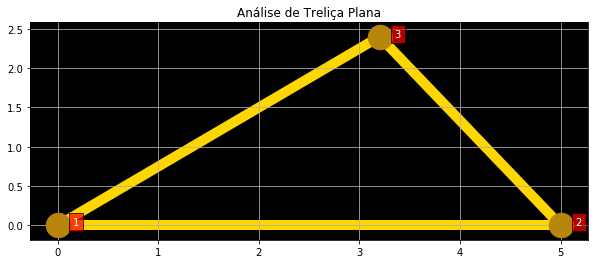

In [164]:
# Função Principal
def main():
    # Configuração do Problema
      # Comentários:
       #atribui a rotina config() à palavra chave "propriedades"
       #sempre que a palavra propriedades for usada, será possivel acessar os dados da rotina config()
    propriedades = config()

    # Determinando as Matrizes Globais
    M, K, P = matrizes(propriedades)

    # Calculando as frequências naturais
    evals, evecs = eigh(K,M)
    freq = np.sqrt(evals)

    # Calculando os deslocamentos estáticos de cada elemento
    U = np.linalg.inv(K).dot(P)

    # Determinando as tensões em cada elemento
    f_axial = det_f_axial(propriedades, U)

    # Resultados
    exibir_resultados(U, f_axial, freq)
    plt.title('Análise de Treliça Plana')
    plt.show()

if __name__ == '__main__': # chamada da Funcao principal
    main()                 # chamada da Função main()

#O uso do “if __name__ == ‘__main__’” para a chamada da função main() permite que esse arquivo seja incluído
#em outros programas(usando “import” e suas variações) sem a necessidade de reescrever ou copiar o código.

## 4. Validação <a name="section_4"></a> 

Para validar os resultados utilizaremos o `Ftool`, um software de análise estrutural 2D reconhecido no meio técnico cuja metodologia de cálculo é similar à utilizada neste artigo.&nbsp; 

Na figura abaixo deslocamentos no nó 2:

<img src="img/img11.png" width="720px"/>

Na figura abaixo deslocamentos no nó 3:

<img src="img/img12.png" width="720px"/>

Na figura abaixo forças axiais nos elementos:

<img src="img/img13.png" width="720px"/>

## 5. Referências<a name="section_5"></a> 

Hibbeler, R. C. Análise das estruturas. São Paulo: Pearson Education do Brasil, 2013.&nbsp;

https://github.com/apf99/Truss-Modeling/blob/master/truss.py &nbsp;

https://panda.ime.usp.br/panda/python/index